<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/NLPSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS6v4bdyXgHf_Fow30-WcUejmgtEW7wGXDvPg&usqp=CAU)

# Setup

In [1]:
pip install transformers

     |████████████████████████████████| 778kB 7.4MB/s 
     |████████████████████████████████| 1.1MB 28.3MB/s 
     |████████████████████████████████| 890kB 52.8MB/s 
     |████████████████████████████████| 3.0MB 48.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4f17d7ca949d3c5ec462ad8e2dee7ca7e0a2e395a95c5a79c510bdae7b133246
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
pip install shifterator

     |████████████████████████████████| 40.4MB 76kB/s 


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shifterator as sh

import nltk
from nltk.corpus import stopwords
from nltk.corpus import subjectivity
from nltk.corpus import twitter_samples
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from transformers import pipeline

# Data
* Subjective: based on or influenced by personal feelings, tastes, or opinions.
* Objective : not influenced by personal feelings or opinions in considering and representing facts.

In [4]:
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Tweets

In [5]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [6]:
pos = [(sent, 'pos') for sent in positive_tweets]
neg = [(sent, 'neg') for sent in negative_tweets]
data_tweets = pos + neg

In [7]:
print(f'There are {len(pos):,} positive sentences')
print(f'There are {len(neg):,} negative sentences')

There are 5,000 positive sentences
There are 5,000 negative sentences


# EDA

In [8]:
stop_words = list(set(stopwords.words('english')))

## Positive

In [9]:
for sent in pos[0:5]:
  print(sent)

('#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)', 'pos')
('@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!', 'pos')
('@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!', 'pos')
('@97sides CONGRATS :)', 'pos')
('yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days', 'pos')


## Negative

In [10]:
for sent in neg[0:5]:
  print(sent)

('hopeless for tmr :(', 'neg')
("Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(", 'neg')
('@Hegelbon That heart sliding into the waste basket. :(', 'neg')
('“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too', 'neg')
('Dang starting next week I have "work" :(', 'neg')


# Results

In [12]:
results_df = pd.DataFrame(columns=['Accuracy'])

# VADER
![alt text](https://t-redactyl.io/figure/Vader_1.jpg)

* Valence Aware Dictionary and sEntiment Reasoner
  * Rules based Sentiment Analysis
  * No training or training data required
  * Works well for social media sentiment
  * Extends well to other domains
  * Can run in a streaming environment (Speed vs Performance)
* Score:
  * Reports Classification Scores for Positive, Negative & Neutral
  * Returns a Compound Score which is normalized from -1 to +1
* Packaged in NLTK but available separately (pip install vaderSentiment)

In [13]:
vader_analyzer = SentimentIntensityAnalyzer()

In [14]:
print(f"I hate you {vader_analyzer.polarity_scores('I hate you')}")
print(f"I love you {vader_analyzer.polarity_scores('I love you')}")

I hate you {'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}
I love you {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}


## Rules

### Punctuation

In [15]:
print(f"I love you {vader_analyzer.polarity_scores('I love you')}")
print(f"I love you! {vader_analyzer.polarity_scores('I love you!')}")
print(f"I love you!! {vader_analyzer.polarity_scores('I love you!!')}")

I love you {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
I love you! {'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'compound': 0.6696}
I love you!! {'neg': 0.0, 'neu': 0.173, 'pos': 0.827, 'compound': 0.6988}


### Capitalization

In [16]:
print(f"I love you {vader_analyzer.polarity_scores('I love you')}")
print(f"I LOVE you {vader_analyzer.polarity_scores('I LOVE you')}")
print(f"I LOVE YOU {vader_analyzer.polarity_scores('I LOVE YOU')}")

I love you {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
I LOVE you {'neg': 0.0, 'neu': 0.169, 'pos': 0.831, 'compound': 0.7125}
I LOVE YOU {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}


### Intensifiers

In [17]:
print(f"I love pizza {vader_analyzer.polarity_scores('I love pizza')}")
print(f"I really love pizza {vader_analyzer.polarity_scores('I really love pizza')}")

I love pizza {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
I really love pizza {'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6697}


### Conjunctions

In [19]:
print(f"I love pizza {vader_analyzer.polarity_scores('I love the pizza')}")
print(f"I love pizza but not the service {vader_analyzer.polarity_scores('I love the pizza but not the service')}")

I love pizza {'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}
I love pizza but not the service {'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.3818}


### Emojis

In [21]:
print(f"I :) pizza {vader_analyzer.polarity_scores('I :) the pizza')}")
print(f"I :-) pizza {vader_analyzer.polarity_scores('I :-) the pizza')}")
print(f"I :( pizza {vader_analyzer.polarity_scores('I :( the pizza')}")
print(f"I :-( pizza {vader_analyzer.polarity_scores('I :-( the pizza')}")

I :) pizza {'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.4588}
I :-) pizza {'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'compound': 0.3182}
I :( pizza {'neg': 0.592, 'neu': 0.408, 'pos': 0.0, 'compound': -0.4404}
I :-( pizza {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}


## Predict

In [22]:
def predict_vader(dataset):
  preds = []
  for sent, label in dataset:
    pred_score = vader_analyzer.polarity_scores(sent)
    pred_class = 'pos' if pred_score['compound'] > 0 else 'neg'
    preds.append((pred_score, pred_class, label))
  return preds

In [23]:
preds = predict_vader(data_tweets)

## Score

In [24]:
def score_vader(preds):
  correct = 0
  for pred_score, pred_class, label in preds:
    if pred_class == label:
      correct += 1
  score = correct / len(preds) * 100.
  return score

In [25]:
acc = score_vader(preds)
results_df.loc['VADER'] = [acc]
print(f'VADER {acc}')

VADER 85.7


# Naive Bayes
![alt text](https://mlalgorithm.files.wordpress.com/2016/06/screenshot-19.png?w=700)

## Preprocessing
* We need to do some pre-processing before we can run NB
* Tweet sentences need to be tokenized
* Drop out stop-words
* Remove punctuation
* Build bag of words 
* Keep top N words
* Featurize words (is present / not present)

In [26]:
cleaned_tweets = []
for sent, label in data_tweets:
  tokens  = sent.split(' ') 
  stopped = [w for w in tokens if not w in stop_words]
  cleaned_tweets.append( (stopped, label) )

In [27]:
all_words_tweets = []
for sent, label in cleaned_tweets:
  all_words_tweets.extend(sent)

In [28]:
TOP = 2500
all_words_tweets = nltk.FreqDist(all_words_tweets)
word_features_tweets = list(all_words_tweets.keys())[:TOP]

In [29]:
def find_features(document, word_features):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

featuresets_tweets = [(find_features(sent, word_features_tweets), label) 
  for sent, label in cleaned_tweets]

## Train - Test

In [30]:
train_tweets, test_tweets = train_test_split(featuresets_tweets)

## Model

In [31]:
classifier = NaiveBayesClassifier.train(train_tweets)

In [32]:
classifier.show_most_informative_features(n=20)

Most Informative Features
                  Thanks = True              pos : neg    =     25.9 : 1.0
                    miss = True              neg : pos    =     19.8 : 1.0
                   Thank = True              pos : neg    =     16.7 : 1.0
               followers = True              pos : neg    =     15.9 : 1.0
                     Let = True              pos : neg    =     15.2 : 1.0
                  thanks = True              pos : neg    =     14.6 : 1.0
                       ) = True              pos : neg    =     13.6 : 1.0
                 welcome = True              pos : neg    =     12.8 : 1.0
                   great = True              pos : neg    =     12.6 : 1.0
                    glad = True              pos : neg    =     12.5 : 1.0
               community = True              pos : neg    =     12.5 : 1.0
                    Love = True              pos : neg    =     12.0 : 1.0
                     via = True              pos : neg    =     11.9 : 1.0

## Test

In [33]:
acc = nltk.classify.accuracy(classifier, test_tweets) * 100.
results_df.loc['Naive Bayes'] = [acc]
print(f'Naive Bayes {acc}')

Naive Bayes 94.12


# TextBlob
* https://textblob.readthedocs.io/en/dev/quickstart.html
* TextBlob an easy to use text-processing interface
* TextBlob objects interoperate as Python strings imbued with NLP skills

In [34]:
print(f"I hate you {TextBlob('I hate you').polarity}")
print(f"I love you {TextBlob('I love you').polarity}")

I hate you -0.8
I love you 0.5


## Predict

In [35]:
def predict_textblob(dataset):
  preds = []
  for sent, label in dataset:
    pred = TextBlob(sent)
    pred_score = pred.polarity
    pred_class = 'pos' if pred_score > 0 else 'neg'
    preds.append((pred_score, pred_class, label))
  return preds

In [36]:
preds = predict_textblob(data_tweets)

## Score

In [37]:
def score_textblob(preds):
  correct = 0
  for pred_score, pred_class, label in preds:
    if pred_class == label:
      correct += 1
  score = correct / len(preds) * 100.
  return score

In [38]:
acc = score_textblob(preds)
results_df.loc['TextBlob'] = [acc]
print(f'TextBlob {acc}')

TextBlob 96.54


# Transformer Pipelines
* Huggingface offers a low code python interface that wraps common functions
* Transformers can be slow for prediction (many computations on the forward pass)
* Speed can be improved using "as a service" & GPUs

In [39]:
nlp = pipeline("sentiment-analysis")
print(nlp('I hate you'))
print(nlp('I love you'))


[{'label': 'NEGATIVE', 'score': 0.9991129040718079}]
[{'label': 'POSITIVE', 'score': 0.9998656511306763}]


In [40]:
for sent, label in data_tweets:
  print(sent, label)
  print(nlp(sent))
  break

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :) pos
[{'label': 'POSITIVE', 'score': 0.9260645508766174}]


## Predict

In [41]:
def predict_pipelines(dataset):
  preds = []
  for sent, label in dataset:
    pred = nlp(sent)
    pred_label = pred[0]['label']
    pred_score = pred[0]['score'] * (1 if pred_label == 'POSITIVE' else -1)
    pred_class = 'pos' if pred_label == 'POSITIVE' else 'neg'
    preds.append((pred_score, pred_class, label))
    if len(preds) % 1000 == 0:
      print(len(preds))
  return preds

In [42]:
preds = predict_pipelines(data_tweets)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


## Score

In [43]:
def score_pipelines(preds):
  correct = 0
  for pred_score, pred_class, label in preds:
    if pred_class == label:
      correct += 1
  score = correct / len(preds) * 100.
  return score

In [44]:
acc = score_pipelines(preds)
results_df.loc['Pipelines'] = [acc]
print(f'Pipelines {acc}')

Pipelines 66.21000000000001


# SpaCy
* SpaCy doesn't have a sentiment implementation
* The typical path with SpaCy involves:
  * Tokenization / Preprocessing with SpaCy
  * A word2vec variant for embeddings
  * LSTM Model for Classification

## Tokenization

In [45]:
nlp = spacy.load('en')
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS
spacy_punk = string.punctuation

parser = English()

def spacy_tokenizer(sentence):
  tokens = parser(sentence)
  tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
  tokens = [ word for word in tokens if word not in spacy_stop_words and word not in spacy_punk ]
  return tokens

In [46]:
spacy_data = [(spacy_tokenizer(sent), label) for sent, label in data_tweets]

In [47]:
spacy_sent  = [sent  for sent, label in data_tweets]
spacy_label = [label for sent, label in data_tweets]

## Vectors

In [48]:
vec_bow = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
bow     = vec_bow.fit_transform(spacy_sent)

## Train - Test

In [49]:
X_train_bow,   X_test_bow,   y_train_bow,   y_test_bow   = train_test_split(bow, spacy_label)

## Model

In [50]:
clf_bow = LogisticRegression()
clf_bow.fit(X_train_bow, y_train_bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Predict

In [51]:
pred_bow   = clf_bow.predict(X_test_bow)

## Score

In [52]:
acc_bow   = accuracy_score(y_test_bow, pred_bow) * 100.
results_df.loc['SpaCy + LR']   = [acc_bow]
print(f'SpaCy + LR {acc_bow}')

SpaCy + LR 98.44000000000001


# Shifterator
* A package that builds shift graphs
* Shift rraphs are vertical bar charts quantifying:
  * Pairwise differences in words between two texts
  * How they contribute to scoring 

In [53]:
spacy_pos_sent  = [sent  for sent, label in pos]
spacy_neg_sent  = [sent  for sent, label in neg]

In [54]:
words_pos_vec = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
words_neg_vec = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

bow_pos = words_pos_vec.fit_transform(spacy_pos_sent)
bow_neg = words_neg_vec.fit_transform(spacy_neg_sent)

In [55]:
pos_df = pd.DataFrame(bow_pos.toarray(), columns=words_pos_vec.get_feature_names())
dict_pos = pos_df.sum().to_dict()

neg_df = pd.DataFrame(bow_neg.toarray(), columns=words_neg_vec.get_feature_names())
dict_neg = neg_df.sum().to_dict()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12299 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12299 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12299 missing from current font.
  font.set_text(s, 0, flags=flags)


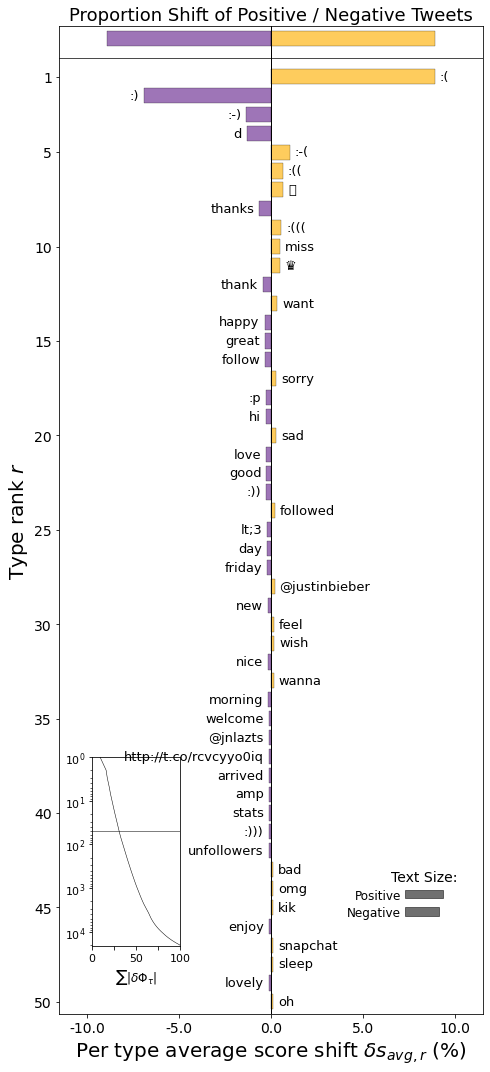

In [56]:
proportion_shift = sh.ProportionShift(type2freq_1=dict_pos,
                                      type2freq_2=dict_neg)
proportion_shift.get_shift_graph(system_names = ['Positive', 'Negative'],
                                 title='Proportion Shift of Positive / Negative Tweets');

# Comparison

In [57]:
results_df['Error Rate'] = 100. - results_df.Accuracy
results_df.sort_values('Error Rate', ascending=False)

,Accuracy,Error Rate
Pipelines,66.21,33.79
VADER,85.70,14.30
Naive Bayes,94.12,5.88
TextBlob,96.54,3.46
SpaCy + LR,98.44,1.56
